<a href="https://colab.research.google.com/github/sthomas522/HF_agents/blob/main/experiments/GenAI_Final_Project_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Full bot

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121

!pip install --upgrade tensorflow
!pip install --upgrade langchain_openai langchain_core langgraph SPARQLWrapper
!pip install --upgrade duckduckgo-search wikipedia wikipedia-api duckduckgo-search
!pip install --upgrade opencv-python yt-dlp pytube
!pip install --upgrade langchain_huggingface langchain_community datasets gradio
!pip install --upgrade pillow spacy librosa
!pip install sentence-transformers
!pip install langchain faiss-cpu


Looking in indexes: https://download.pytorch.org/whl/cu121
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 94.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 123.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.9 MB/s e

In [3]:
import os
import re
import tempfile
from typing import TypedDict, List, Optional, Dict, Any

import cv2
import requests
import wikipedia
from PIL import Image
import torch
import glob
import shutil

from langchain.docstore.document import Document
from langchain.prompts import PromptTemplate
from langchain_community.document_loaders import WikipediaLoader
from langchain_huggingface import HuggingFaceEndpoint
from langgraph.graph import START, END, StateGraph
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage # If you are using it
from langchain_community.retrievers import BM25Retriever # If you are using it
from langgraph.prebuilt import ToolNode, tools_condition # If you are using it
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.schema import Document

from transformers import BlipProcessor, BlipForQuestionAnswering, pipeline

import spacy
import yt_dlp
from io import BytesIO
from duckduckgo_search import DDGS
import librosa
from sentence_transformers import SentenceTransformer

#from tools import * # Assuming this file is in a location accessible from the current directory or you've set up the correct import path.

In [4]:
nlp = spacy.load("en_core_web_sm")


In [5]:
# API endpoint for retrieving the list of questions
url = "https://agents-course-unit4-scoring.hf.space/questions"

# Send GET request
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    questions = response.json()
    print(questions)
else:
    print(f"Failed to retrieve questions. Status code: {response.status_code}")
    print(response.text)


questions = [item['question'] for item in response.json()]

# full details
hf_questions = response.json()


[{'task_id': '8e867cd7-cff9-4e6c-867a-ff5ddc2550be', 'question': 'How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.', 'Level': '1', 'file_name': ''}, {'task_id': 'a1e91b78-d3d8-4675-bb8d-62741b4b68a6', 'question': 'In the video https://www.youtube.com/watch?v=L1vXCYZAYYM, what is the highest number of bird species to be on camera simultaneously?', 'Level': '1', 'file_name': ''}, {'task_id': '2d83110e-a098-4ebb-9987-066c06fa42d0', 'question': '.rewsna eht sa "tfel" drow eht fo etisoppo eht etirw ,ecnetnes siht dnatsrednu uoy fI', 'Level': '1', 'file_name': ''}, {'task_id': 'cca530fc-4052-43b2-b130-b30968d8aa44', 'question': "Review the chess position provided in the image. It is black's turn. Provide the correct next move for black which guarantees a win. Please provide your response in algebraic notation.", 'Level': '1', 'file_name': 'cca530fc-4052-43b2-b130-b30968d8aa44.png'}, {'task_id': 

In [6]:
# Define file extension sets for each category
PICTURE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp'}
AUDIO_EXTENSIONS = {'.mp3', '.wav', '.aac', '.flac', '.ogg', '.m4a', '.wma'}
CODE_EXTENSIONS = {'.py', '.js', '.java', '.cpp', '.c', '.cs', '.rb', '.go', '.php', '.html', '.css', '.ts'}
SPREADSHEET_EXTENSIONS = {
    '.xls', '.xlsx', '.xlsm', '.xlsb', '.xlt', '.xltx', '.xltm',
    '.ods', '.ots', '.csv', '.tsv', '.sxc', '.stc', '.dif', '.gsheet',
    '.numbers', '.numbers-tef', '.nmbtemplate', '.fods', '.123', '.wk1', '.wk2',
    '.wks', '.wku', '.wr1', '.gnumeric', '.gnm', '.xml', '.pmvx', '.pmdx',
    '.pmv', '.uos', '.txt'
}

def get_file_type(filename: str) -> str:
    if not filename or '.' not in filename or filename == '':
        return ''
    ext = filename.lower().rsplit('.', 1)[-1]
    dot_ext = f'.{ext}'
    if dot_ext in PICTURE_EXTENSIONS:
        return 'picture'
    elif dot_ext in AUDIO_EXTENSIONS:
        return 'audio'
    elif dot_ext in CODE_EXTENSIONS:
        return 'code'
    elif dot_ext in SPREADSHEET_EXTENSIONS:
        return 'spreadsheet'
    else:
        return 'unknown'

In [7]:
for h in hf_questions:
  print(h['question'])

How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.
In the video https://www.youtube.com/watch?v=L1vXCYZAYYM, what is the highest number of bird species to be on camera simultaneously?
.rewsna eht sa "tfel" drow eht fo etisoppo eht etirw ,ecnetnes siht dnatsrednu uoy fI
Review the chess position provided in the image. It is black's turn. Provide the correct next move for black which guarantees a win. Please provide your response in algebraic notation.
Who nominated the only Featured Article on English Wikipedia about a dinosaur that was promoted in November 2016?
Given this table defining * on the set S = {a, b, c, d, e}

|*|a|b|c|d|e|
|---|---|---|---|---|---|
|a|a|b|c|b|d|
|b|b|c|a|e|c|
|c|c|a|b|b|a|
|d|b|e|b|e|d|
|e|d|b|a|d|c|

provide the subset of S involved in any possible counter-examples that prove * is not commutative. Provide your answer as a comma separated list of the elements in 

In [8]:
def write_bytes_to_temp_dir(file_bytes: bytes, file_name: str) -> str:
    """
    Writes bytes to a file in the system temporary directory using the provided file_name.
    Returns the full path to the saved file.
    The file will persist until manually deleted or the OS cleans the temp directory.
    """
    temp_dir = tempfile.gettempdir()
    file_path = os.path.join(temp_dir, file_name)
    with open(file_path, 'wb') as f:
        f.write(file_bytes)
    print(f"File written to: {file_path}")
    return file_path


In [9]:
API_URL = 'https://agents-course-unit4-scoring.hf.space/files'
for item in hf_questions:
    file_name = item.get('file_name', '')
    if file_name == '':
        item['input_file'] = None
        item['file_type'] = None
        item['file_path'] = None
    else:
        # Call the API to retrieve the file; adjust params as needed
        task_id = item['task_id']
        api_response = requests.get(f"{API_URL}/{task_id}")
        if api_response.status_code == 200:
            item['input_file'] = api_response.content  # Store file as bytes
            item['file_type'] = get_file_type(file_name)
            item['file_path'] = write_bytes_to_temp_dir(item['input_file'], file_name)
        else:
            item['input_file'] = None  # Or handle error as needed

File written to: /tmp/cca530fc-4052-43b2-b130-b30968d8aa44.png
File written to: /tmp/99c9cc74-fdc8-46c6-8f8d-3ce2d3bfeea3.mp3
File written to: /tmp/f918266a-b3e0-4914-865d-4faa564f1aef.py
File written to: /tmp/1f975693-876d-457b-a649-393859e79bf3.mp3
File written to: /tmp/7bd855d8-463d-4ed5-93ca-5fe35145f733.xlsx


In [10]:
[type(hf_questions[i]['input_file']) for i in range(20)]

[NoneType,
 NoneType,
 NoneType,
 bytes,
 NoneType,
 NoneType,
 NoneType,
 NoneType,
 NoneType,
 bytes,
 NoneType,
 bytes,
 NoneType,
 bytes,
 NoneType,
 NoneType,
 NoneType,
 NoneType,
 bytes,
 NoneType]

In [11]:
import os
import re
from PIL import Image  # This is correctly imported, but was being used incorrectly
import numpy as np
from collections import Counter
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering, pipeline
from typing import TypedDict, List, Optional, Dict, Any, Literal, Tuple
from langgraph.graph import StateGraph, START, END
from langchain.docstore.document import Document

# 1. Define the State type
class State(TypedDict, total=False):
    question: str
    task_id: str
    input_file: bytes
    file_type: str
    context: List[Document]  # Using LangChain's Document class
    file_path: Optional[str]
    youtube_url: Optional[str]
    answer: Optional[str]
    frame_answers: Optional[list]
    next: Optional[str]  # Added to track the next node

# --- LLM pipeline for general questions ---
llm_pipe = pipeline("text-generation",
                    #model="meta-llama/Llama-3.3-70B-Instruct",
                    #model="meta-llama/Meta-Llama-3-8B-Instruct",
                    #model="Qwen/Qwen2-7B-Instruct",
                    #model="microsoft/Phi-4-reasoning",
                    model="microsoft/Phi-3-mini-4k-instruct",
                    device_map="auto",
                    #device_map={ "": 0 },  # "" means the whole model
                    #max_memory={0: "10GiB"},
                    torch_dtype="auto",
                    max_new_tokens=256)

# Speech-to-text pipeline
asr_pipe = pipeline(
    "automatic-speech-recognition",
    model="openai/whisper-small",
    device=-1
    #device_map={"", 0},
    #max_memory = {0: "4.5GiB"},
    #device_map="auto"
)

# --- Your BLIP VQA setup ---
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
vqa_model_name = "Salesforce/blip-vqa-base"
processor_vqa = BlipProcessor.from_pretrained(vqa_model_name)

# Attempt to load model to GPU; fall back to CPU if OOM
try:
    model_vqa = BlipForQuestionAnswering.from_pretrained(vqa_model_name).to(device)
except torch.cuda.OutOfMemoryError:
    print("WARNING: Loading model to CPU due to insufficient GPU memory.")
    device = "cpu"  # Switch device to CPU
    model_vqa = BlipForQuestionAnswering.from_pretrained(vqa_model_name).to(device)


# --- Helper: Answer question on a single frame ---
def answer_question_on_frame(image_path, question):
    # Fixed: Properly use the PIL Image module
    image = Image.open(image_path).convert('RGB')
    inputs = processor_vqa(image, question, return_tensors="pt").to(device)
    out = model_vqa.generate(**inputs)
    answer = processor_vqa.decode(out[0], skip_special_tokens=True)
    return answer

# --- Helper: Answer question about the whole video ---
def answer_video_question(frames_dir, question):
    valid_exts = ('.jpg', '.jpeg', '.png')

    # Check if directory exists
    if not os.path.exists(frames_dir):
        return {
            "most_common_answer": "No frames found to analyze.",
            "all_answers": [],
            "answer_counts": Counter()
        }

    frame_files = [os.path.join(frames_dir, f) for f in os.listdir(frames_dir)
                  if f.lower().endswith(valid_exts)]

    # Sort frames properly by number
    def get_frame_number(filename):
        match = re.search(r'(\d+)', os.path.basename(filename))
        return int(match.group(1)) if match else 0

    frame_files = sorted(frame_files, key=get_frame_number)

    if not frame_files:
        return {
            "most_common_answer": "No valid image frames found.",
            "all_answers": [],
            "answer_counts": Counter()
        }

    answers = []
    for frame_path in frame_files:
        try:
            ans = answer_question_on_frame(frame_path, question)
            answers.append(ans)
            print(f"Processed frame: {os.path.basename(frame_path)}, Answer: {ans}")
        except Exception as e:
            print(f"Error processing frame {frame_path}: {str(e)}")

    if not answers:
        return {
            "most_common_answer": "Could not analyze any frames successfully.",
            "all_answers": [],
            "answer_counts": Counter()
        }

    counted = Counter(answers)
    most_common_answer, freq = counted.most_common(1)[0]
    return {
        "most_common_answer": most_common_answer,
        "all_answers": answers,
        "answer_counts": counted
    }


def download_youtube_video(url, output_dir='/content/video/', output_filename='downloaded_video.mp4'):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Delete all files in the output directory
    files = glob.glob(os.path.join(output_dir, '*'))
    for f in files:
        try:
            os.remove(f)
        except Exception as e:
            print(f"Error deleting {f}: {str(e)}")

    # Set output path for yt-dlp
    output_path = os.path.join(output_dir, output_filename)

    ydl_opts = {
        'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]/best',
        'outtmpl': output_path,
        'quiet': True,
        'merge_output_format': 'mp4',  # Ensures merged output is mp4
        'postprocessors': [{
            'key': 'FFmpegVideoConvertor',
            'preferedformat': 'mp4',  # Recode if needed
        }]
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])
    return output_path



# --- Helper: Extract frames from video ---
def extract_frames(video_path, output_dir, frame_interval_seconds=10):
    # --- Clean output directory before extracting new frames ---
    if os.path.exists(output_dir):
        for filename in os.listdir(output_dir):
            file_path = os.path.join(output_dir, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')
    else:
        os.makedirs(output_dir, exist_ok=True)

    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print("Error: Could not open video.")
            return False
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_interval = int(fps * frame_interval_seconds)
        count = 0
        saved = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if count % frame_interval == 0:
                frame_filename = os.path.join(output_dir, f"frame_{count:06d}.jpg")
                cv2.imwrite(frame_filename, frame)
                saved += 1
            count += 1
        cap.release()
        print(f"Extracted {saved} frames.")
        return saved > 0
    except Exception as e:
        print(f"Exception during frame extraction: {e}")
        return False

def image_qa(image_path: str, question: str, model_name: str = vqa_model_name) -> str:
    """
    Answers questions about images using Hugging Face's VQA pipeline.

    Args:
        image_path: Path to local image file or URL
        question: Natural language question about the image
        model_name: Pretrained VQA model (default: good general-purpose model)

    Returns:
        str: The model's best answer
    """
    # Create VQA pipeline with specified model
    vqa_pipeline = pipeline("visual-question-answering", model=model_name)

    # Get predictions (automatically handles local files/URLs)
    results = vqa_pipeline(image=image_path, question=question, top_k=1)

    # Return top answer
    return results[0]['answer']


def router(state: Dict[str, Any]) -> str:
    """Determine the next node based on whether the question contains a YouTube URL or references Wikipedia."""
    question = state.get('question', '')


    # Pattern for Wikipedia and similar sources
    wiki_pattern = r"(wikipedia\.org|wiki|encyclopedia|britannica\.com|encyclop[a|æ]dia)"
    has_wiki = re.search(wiki_pattern, question, re.IGNORECASE) is not None

    # Pattern for YouTube
    yt_pattern = r"(https?://)?(www\.)?(youtube\.com|youtu\.be)/[^\s]+"
    has_youtube = re.search(yt_pattern, question) is not None

    # Check for image
    has_image = state.get('file_type') == 'picture'

    # Check for audio
    has_audio = state.get('file_type') == 'audio'

    print(f"Has Wikipedia reference: {has_wiki}")
    print(f"Has YouTube link: {has_youtube}")
    print(f"Has picture file: {has_image}")
    print(f"Has audio file: {has_audio}")

    if has_wiki:
        return "retrieve"
    elif has_youtube:
        # Store the extracted YouTube URL in the state
        url_match = re.search(r"(https?://[^\s]+)", question)
        if url_match:
            state['youtube_url'] = url_match.group(0)
        return "video"
    elif has_image:
        return "image"
    elif has_audio:
        return "audio"
    else:
        return "llm"


# --- Node Implementation ---
def node_image(state: Dict[str, Any]) -> Dict[str, Any]:
  """Router node that decides which node to go to next."""
  print("Running node_image")
  # Add the next state to the state dict
  img = Image.open(state['file_path'])
  state['answer'] = image_qa(state['file_path'], state['question'])
  return state


def node_decide(state: Dict[str, Any]) -> Dict[str, Any]:
    """Router node that decides which node to go to next."""
    print("Running node_decide")
    # Add the next state to the state dict
    state["next"] = router(state)
    print(f"Routing to: {state['next']}")
    return state

def node_video(state: Dict[str, Any]) -> Dict[str, Any]:
    print("Running node_video")
    youtube_url = state.get('youtube_url')
    if not youtube_url:
        state['answer'] = "No YouTube URL found in the question."
        return state

    question = state['question']
    # Extract the actual question part (remove the URL)
    question_text = re.sub(r'https?://[^\s]+', '', question).strip()
    if not question_text.endswith('?'):
        question_text += '?'

    video_file = download_youtube_video(youtube_url)
    if not video_file or not os.path.exists(video_file):
        state['answer'] = "Failed to download the video."
        return state

    frames_dir = "/tmp/frames"
    os.makedirs(frames_dir, exist_ok=True)

    success = extract_frames(video_path=video_file, output_dir=frames_dir, frame_interval_seconds=10)
    if not success:
        state['answer'] = "Failed to extract frames from the video."
        return state

    result = answer_video_question(frames_dir, question_text)
    state['answer'] = result['most_common_answer']
    state['frame_answers'] = result['all_answers']

    # Create Document objects for each frame analysis
    frame_documents = []
    for i, ans in enumerate(result['all_answers']):
        doc = Document(
            page_content=f"Frame {i}: {ans}",
            metadata={"frame_number": i, "source": "video_analysis"}
        )
        frame_documents.append(doc)

    # Add documents to state if not already present
    if 'context' not in state:
        state['context'] = []
    state['context'].extend(frame_documents)

    print(f"Video answer: {state['answer']}")
    return state

def node_audio_rag(state: Dict[str, Any]) -> Dict[str, Any]:
    print(f"Processing audio file: {state['file_path']}")

    try:
        # Step 1: Transcribe audio
        audio, sr = librosa.load(state['file_path'], sr=16000)
        asr_result = asr_pipe({"raw": audio, "sampling_rate": sr})
        audio_transcript = asr_result['text']
        print(f"Audio transcript: {audio_transcript}")

        # Step 2: Store ONLY the transcript in the vector store
        transcript_doc = [Document(page_content=audio_transcript)]
        embeddings = HuggingFaceEmbeddings(model_name='BAAI/bge-large-en-v1.5')
        vector_db = FAISS.from_documents(transcript_doc, embedding=embeddings)

        # Step 3: Retrieve relevant docs for the user's question
        question = state['question']
        similar_docs = vector_db.similarity_search(question, k=1)  # Only one doc in store
        retrieved_context = "\n".join([doc.page_content for doc in similar_docs])

        # Step 4: Augment prompt and generate answer
        prompt = (
            f"Use the following context to answer the question.\n"
            f"Context:\n{retrieved_context}\n\n"
            f"Question: {question}\nAnswer:"
        )
        llm_response = llm_pipe(prompt)
        state['answer'] = llm_response[0]['generated_text']

    except Exception as e:
        error_msg = f"Audio processing error: {str(e)}"
        print(error_msg)
        state['answer'] = error_msg

    return state

def node_llm(state: Dict[str, Any]) -> Dict[str, Any]:
    print("Running node_llm")
    question = state['question']

    # Optionally add context from state (e.g., Wikipedia/Wikidata content)
    context_text = ""
    if 'article_content' in state and state['article_content']:
        context_text = f"\n\nBackground Information:\n{state['article_content']}\n"
    elif 'context' in state and state['context']:
        context_text = "\n\n".join([doc.page_content for doc in state['context']])

    # Compose a detailed prompt
    prompt = (
        "You are a general AI assistant. I will ask you a question."
        "Report your thoughts, and finish your answer with the following template: "
        "FINAL ANSWER: YOUR FINAL ANSWER"
        "should be a number OR as few words as possible OR a comma separated list of numbers and/or strings."
        "If you are asked for a number, don't use comma to write your number neither use units such as $ or percent"
        "sign unless specified otherwise. If you are asked for a string, don't use articles, neither abbreviations"
         "(e.g. for cities), and write the digits in plain text unless specified otherwise. If you are asked for a"
        "comma separated list, apply the above rules depending of whether the element to be put in the list is a number or a string."
        f"Question: {question }"
        f"{context_text}\n"
    )

    # Add document to state for traceability
    query_doc = Document(
        page_content=prompt,
        metadata={"source": "llm_prompt"}
    )
    if 'context' not in state:
        state['context'] = []
    state['context'].append(query_doc)

    try:
        result = llm_pipe(prompt)
        state['answer'] = result[0]['generated_text']
    except Exception as e:
        print(f"Error in LLM processing: {str(e)}")
        state['answer'] = f"An error occurred while processing your question: {str(e)}"

    print(f"LLM answer: {state['answer']}")
    return state


# --- Define the edge condition function ---
def get_next_node(state: Dict[str, Any]) -> str:
    """Get the next node from the state."""
    return state["next"]


# 2. Improved Wikipedia Retrieval Node
def extract_keywords(question: str) -> List[str]:
    doc = nlp(question)
    keywords = [token.text for token in doc if token.pos_ in ("PROPN", "NOUN")]  # Extract proper nouns and nouns
    return keywords

def extract_entities(question: str) -> List[str]:
    doc = nlp(question)
    entities = [ent.text for ent in doc.ents]
    return entities if entities else [token.text for token in doc if token.pos_ in ("PROPN", "NOUN")]


def retrieve(state: State) -> dict:
    keywords = extract_entities(state["question"])
    query = " ".join(keywords)
    search_results = wikipedia.search(query)
    selected_page = search_results[0] if search_results else None

    if selected_page:
        loader = WikipediaLoader(
            query=selected_page,
            lang="en",
            load_max_docs=1,
            doc_content_chars_max=100000,
            load_all_available_meta=True
        )
        docs = loader.load()
        # Chunk the article for finer retrieval
        from langchain.text_splitter import RecursiveCharacterTextSplitter
        splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=200)
        all_chunks = []
        for doc in docs:
            chunks = splitter.split_text(doc.page_content)
            all_chunks.extend([Document(page_content=chunk) for chunk in chunks])
        # Optionally: re-rank or filter chunks here
        return {"context": all_chunks}
    else:
        return {"context": []}

# 3. Prompt Template for General QA
prompt = PromptTemplate(
    input_variables=["question", "context"],
    template=(
        "You are a general AI assistant. I will ask you a question."
        "Report your thoughts, and finish your answer with the following template: "
        "FINAL ANSWER: [YOUR FINAL ANSWER]. YOUR FINAL ANSWER"
        "should be a number OR as few words as possible OR a comma separated list of numbers and/or strings."
        "If you are asked for a number, don't use comma to write your number neither use units such as $ or percent"
        "sign unless specified otherwise. If you are asked for a string, don't use articles, neither abbreviations"
         "(e.g. for cities), and write the digits in plain text unless specified otherwise. If you are asked for a"
        "comma separated list, apply the above rules depending of whether the element to be put in the list is a number or a string."


        "Use the following context from Wikipedia to help answer the user's question as accurately as possible. "
        "If the text appears to be scrambled, try to unscramble the text for the user"
        "If the information is incomplete or ambiguous, provide your best estimate based on the available evidence, and clearly explain any assumptions or reasoning you use. "
    )
)

def generate(state: dict) -> dict:
    # Concatenate all context documents into a single string
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    # Format the prompt for the LLM
    prompt_str = prompt.format(question=state["question"], context=docs_content)
    # Generate answer using Hugging Face pipeline
    response = llm_pipe(prompt_str)
    # Extract generated text
    answer = response[0]["generated_text"]
    return {"answer": answer}

# Create the StateGraph
graph = StateGraph(State)

# Add nodes
graph.add_node("decide", node_decide)
graph.add_node("video", node_video)
graph.add_node("llm", node_llm)
graph.add_node("retrieve", retrieve)
graph.add_node("generate", generate)
graph.add_node("image", node_image)
graph.add_node("audio", node_audio_rag)

# Add edge from START to decide
graph.add_edge(START, "decide")
graph.add_edge("retrieve", "generate")

# Add conditional edges from decide to video or llm based on question
graph.add_conditional_edges(
    "decide",
    get_next_node,
    {
        "video": "video",
        "llm": "llm",
        "retrieve": "retrieve",
        "image": "image",
        "audio": "audio"
    }
)

# Add edges from video and llm to END to terminate the graph
graph.add_edge("video", END)
graph.add_edge("llm", END)
graph.add_edge("generate", END)
graph.add_edge("image", END)
graph.add_edge("audio", END)

# Compile the graph
agent = graph.compile()

# --- Usage Example ---
def intelligent_agent(state: State) -> str:
    """Process a question using the appropriate pipeline based on content."""
    #state = State(question= question)
    try:
        final_state = agent.invoke(state)
        return final_state.get('answer', "No answer found.")
    except Exception as e:
        print(f"Error in agent execution: {str(e)}")
        return f"An error occurred: {str(e)}"

# --- Try it! ---
# Test with a YouTube question
#question = "What are the people doing in https://www.youtube.com/watch?v=YTR21os8gTA ?"
#print(intelligent_agent(questions[3]))

#question = "What are the people doing in https://www.youtube.com/watch?v=WDJ-mhWluJY ?"
#print(intelligent_agent(question))

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

Device set to use cpu
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

In [12]:
qnum = 2

In [13]:
s = State(question = hf_questions[qnum]['question'],
          input_file = hf_questions[qnum]['input_file'],
          file_type = hf_questions[qnum]['file_type'],
          file_path = hf_questions[qnum]['file_path'])

In [14]:
s['file_path']

In [15]:
print(s['question'])
#intelligent_agent(s)

.rewsna eht sa "tfel" drow eht fo etisoppo eht etirw ,ecnetnes siht dnatsrednu uoy fI


In [16]:
ans = []
for r in range(len(hf_questions)):
  s = State(question = hf_questions[r]['question'],
            input_file = hf_questions[r]['input_file'],
            file_type = hf_questions[r]['file_type'],
            file_path = hf_questions[r]['file_path'])
  print(s['question'])
  temp_ans = intelligent_agent(s)
  print(temp_ans)
  print('\n')
  ans.append(temp_ans)

How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.
Running node_decide
Has Wikipedia reference: True
Has YouTube link: False
Has picture file: False
Has audio file: False
Routing to: retrieve
You are a general AI assistant. I will ask you a question.Report your thoughts, and finish your answer with the following template: FINAL ANSWER: [YOUR FINAL ANSWER]. YOUR FINAL ANSWERshould be a number OR as few words as possible OR a comma separated list of numbers and/or strings.If you are asked for a number, don't use comma to write your number neither use units such as $ or percentsign unless specified otherwise. If you are asked for a string, don't use articles, neither abbreviations(e.g. for cities), and write the digits in plain text unless specified otherwise. If you are asked for acomma separated list, apply the above rules depending of whether the element to be put in the list is a number or 

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


1


Who nominated the only Featured Article on English Wikipedia about a dinosaur that was promoted in November 2016?
Running node_decide
Has Wikipedia reference: True
Has YouTube link: False
Has picture file: False
Has audio file: False
Routing to: retrieve
You are a general AI assistant. I will ask you a question.Report your thoughts, and finish your answer with the following template: FINAL ANSWER: [YOUR FINAL ANSWER]. YOUR FINAL ANSWERshould be a number OR as few words as possible OR a comma separated list of numbers and/or strings.If you are asked for a number, don't use comma to write your number neither use units such as $ or percentsign unless specified otherwise. If you are asked for a string, don't use articles, neither abbreviations(e.g. for cities), and write the digits in plain text unless specified otherwise. If you are asked for acomma separated list, apply the above rules depending of whether the element to be put in the list is a number or a string.Use the following co

/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.


Audio transcript:  In a saucepan, combine ripe strawberries, granulated sugar, freshly squeezed lemon juice and corn starch. Cook the mixture over medium heat, stirring constantly until it thickens to a smooth consistency. Remove from heat and stir in a dash of pure vanilla extract. Allow the strawberry pie filling to cool before using it as a delicious and fruity filling for your pie crust.


<ipython-input-11-888e85cc0acc>:337: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name='BAAI/bge-large-en-v1.5')


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Use the following context to answer the question.
Context:
 In a saucepan, combine ripe strawberries, granulated sugar, freshly squeezed lemon juice and corn starch. Cook the mixture over medium heat, stirring constantly until it thickens to a smooth consistency. Remove from heat and stir in a dash of pure vanilla extract. Allow the strawberry pie filling to cool before using it as a delicious and fruity filling for your pie crust.

Question: Hi, I'm making a pie but I could use some help with my shopping list. I have everything I need for the crust, but I'm not sure about the filling. I got the recipe from my friend Aditi, but she left it as a voice memo and the speaker on my phone is buzzing so I can't quite make out what she's saying. Could you please listen to the recipe and list all of the ingredients that my friend described? I only want the ingredients for the filling, as I have everything I need to make my favorite pie crust. I've attached the recipe as Strawberry pie.mp3.

In 

/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


LLM answer: Question: How many at bats did the Yankee with the most walks in the 1977 regular season have that same season?
You are a general AI assistant. I will ask you a question.Report your thoughts, and finish your answer with the following template: FINAL ANSWER: [YOUR FINAL ANSWER]. YOUR FINAL ANSWERshould be a number OR as few words as possible OR a comma separated list of numbers and/or strings.If you are asked for a number, don't use comma to write your number neither use units such as $ or percentsign unless specified otherwise. If you are asked for a string, don't use articles, neither abbreviations(e.g. for cities), and write the digits in plain text unless specified otherwise. If you are asked for acomma separated list, apply the above rules depending of whether the element to be put in the list is a number or a string.

Question:In the 1977 regular season, who had the most walks in the American League and how many at bats did he have that same season?
Answer:FINAL ANSWER

In [17]:
import pickle

# Save the object to a file
filename = "hf_ans.pkl"
with open(filename, "wb") as file:
    pickle.dump(ans, file)

In [18]:
len(ans)

20

In [19]:
for i in range(len(ans)):
  print(f"Answer {i+1}: {ans[i]}\n")


Answer 1: You are a general AI assistant. I will ask you a question.Report your thoughts, and finish your answer with the following template: FINAL ANSWER: [YOUR FINAL ANSWER]. YOUR FINAL ANSWERshould be a number OR as few words as possible OR a comma separated list of numbers and/or strings.If you are asked for a number, don't use comma to write your number neither use units such as $ or percentsign unless specified otherwise. If you are asked for a string, don't use articles, neither abbreviations(e.g. for cities), and write the digits in plain text unless specified otherwise. If you are asked for acomma separated list, apply the above rules depending of whether the element to be put in the list is a number or a string.Use the following context from Wikipedia to help answer the user's question as accurately as possible. If the text appears to be scrambled, try to unscramble the text for the userIf the information is incomplete or ambiguous, provide your best estimate based on the ava

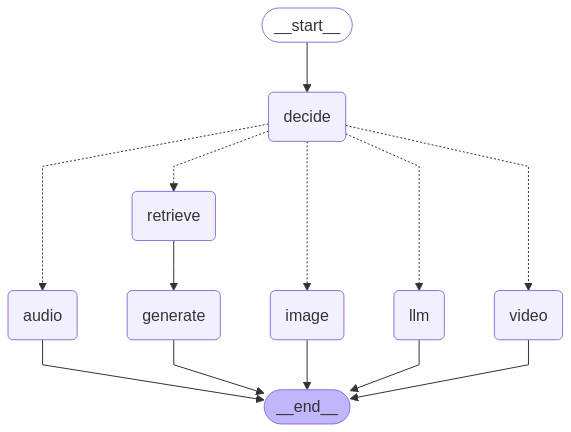

In [20]:
#from IPython.display import display
import IPython.display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

IPython.display.display(
    IPython.display.Image(
        agent.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [29]:
# Extract the last occurrence of 'FINAL ANSWER:' and text after it until a newline
final_answers = []
for s in ans:
    matches = re.findall(r'FINAL ANSWER: ([^\n]*)', s)
    if matches:
        final_answers.append(matches[-1])
    else:
        final_answers.append(None)  # or '' for empty string

print(final_answers)

['11', None, '9', None, '11', '[YOUR FINAL ANSWER]. YOUR FINAL ANS', None, '1.E Exercises, Marisa Alviar-Agnew, Henry Agnew, CK-12, LibreTexts, Introductory Chemistry, 08/21/2023', "[YOUR FINAL ANSWER]. YOUR FINAL ANSWERshould be a number OR as few words as possible OR a comma separated list of numbers and/or strings.If you are asked for a number, don't use comma to write your number neither use units such as $ or percentsign unless specified otherwise. If you are asked for a string, don't use articles, neither abbreviations(e.g. for cities), and write the digits in plain text unless specified otherwise. If you are asked for acomma separated list, apply the above rules depending of whether the element to be put in the list is a number or a string.", None, "[YOUR FINAL ANSWER]. YOUR FINAL ANSWERshould be a number OR as few words as possible OR a comma separated list of numbers and/or strings.If you are asked for a number, don't use comma to write your number neither use units such as $ 

In [59]:
final_answers[5]


'[YOUR FINAL ANSWER]. YOUR FINAL ANS'

In [60]:
hf_questions[5]

{'task_id': '6f37996b-2ac7-44b0-8e68-6d28256631b4',
 'question': 'Given this table defining * on the set S = {a, b, c, d, e}\n\n|*|a|b|c|d|e|\n|---|---|---|---|---|---|\n|a|a|b|c|b|d|\n|b|b|c|a|e|c|\n|c|c|a|b|b|a|\n|d|b|e|b|e|d|\n|e|d|b|a|d|c|\n\nprovide the subset of S involved in any possible counter-examples that prove * is not commutative. Provide your answer as a comma separated list of the elements in the set in alphabetical order.',
 'Level': '1',
 'file_name': '',
 'input_file': None,
 'file_type': None,
 'file_path': None}

In [21]:
os.getcwd()

'/content'